# Compound bar assembly under 2D loading

This notebook runs the complete analysis of the compound bar assembly. The assembly consists of two components, a hollow tube and a solid bar of two dissimilar materials. The assembly is clamped at the bottom and the free end is constrained such that both the bar and the tube have equal longitudinal deformations (strains) upon loading. 

This notebook covers

- Generating external load cases
- Identifying external characteristic loads
- Computing internal loads within the assembly
- Computing internal characteristic loads
- Building performance envelopes and adaptive refining envelope
- Fast RF estimation
- Sensitivity calculations and validation
- List of future work 

<img src="files/compoundBar.png" alt="compoundBar" style="width: 200px;"/>

An overview of the names of the the different loads and process is given here


<img src="files/compoundBar_namingConvention.png" alt="compoundBar_nameingConvention" style="width: 75%;" />

In [1]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from IPython.display import display

%run functions_compoundBar.ipynb
%run functions_commonFiles.ipynb
%matplotlib inline

plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['font.size'] = 10
# plt.style.use('classic')

In [2]:
# load material data

#Tube Aluminum 6061-O http://www.matweb.com/search/DataSheet.aspx?MatGUID=626ec8cdca604f1994be4fc2bc6f7f63
x1 = 0.2 #m
x2 = 0.18 #m
E1 = 70e9 #pa
ten1 = 55.2e6 #Tensile yield strenght pa
com1 = -103e6 #bearing yield strength pa

#Bar steel ASTM A36 Steel http://www.matweb.com/search/datasheet.aspx?matguid=d1844977c5c8440cb9a3a967f8909c3a&ckck=1
x3 = 0.11
E2 = 200e9
ten2 = 250e6 #tension yield strength
com2 = -152e6 #compressive yield strength

#Analysis parameters
RFtol = 0.001 #checks the RF tolerance
thetaInitial = np.deg2rad([0,90,180,270])
r_ini = 10e0

flag_balance_external_load = True
flag_balance_internal_load = True
maxPoints =20

# Precalculations and assignments
A2 = np.pi * x3**2
A1 = np.pi*x1**2 - np.pi*x2**2

I2 = (np.pi/4)*x3**4
I1 = (np.pi/4)*(x1**4 - x2**4)

k1 = E1*A1 + E2*A2
k2 = E1*I1 + E2*I2

y1 = x1
y2 = x3

prop = {
    'x1' : x1,
    'x2' : x2,
    'x3' : x3,
    'A1' : A1,
    'A2' : A2,
    'I1' : I1,
    'I2' : I2,
    'k1' : k1,
    'k2' : k2,
    'y1' : y1,
    'y2' : y2,
    'E1' : E1,
    'E2' : E2,
    'ten1' :ten1,
    'ten2' : ten2,
    'com1' : com1,
    'com2' : com2,
}

# Generating load cases

A spring-mass-damper system is solved to generate axial loads and bending moment. External loads set is represented by $P$

$$P = 
 \begin{bmatrix}
 F_1 & M_1 \\
 F_2 & M_2 \\
 \vdots & \vdots\\
 F_m & M_m 
 \end{bmatrix}
$$

In [3]:
#Generate load cases 
arm = 0.3
F1,t = loadGen(1e5,120,30,2,0.3,5e3) #loadGen(m,v_ini,t_end,t_int, d_ratio, k)
M,t = loadGen(1e5,110,30,2,0.5,9e3)
# F1,t = loadGen(500,12,30,2,0.8,5e0) #loadGen(m,v_ini,t_end,t_int, d_ratio, k)
# M,t = loadGen(500,11,30,2,0.6,9e0)
F = F1
M = -M*arm
M = np.flip(M,0)
P = np.hstack([F,M]) #External loads matrix

In [4]:
P

array([[ 0.00000000e+00, -1.43447828e+04],
       [ 1.01779443e+06, -1.05169975e+04],
       [ 1.62047432e+06,  1.49254845e+03],
       [ 1.80176348e+06,  2.26608311e+04],
       [ 1.62955845e+06,  5.03833988e+04],
       [ 1.21675943e+06,  7.67768579e+04],
       [ 6.91202075e+05,  8.81130192e+04],
       [ 1.70089192e+05,  6.65859660e+04],
       [-2.57726047e+05, -4.51598321e+03],
       [-5.40396591e+05, -1.31910220e+05],
       [-6.63316693e+05, -3.00887469e+05],
       [-6.42877122e+05, -4.64738384e+05],
       [-5.16342709e+05, -5.40807162e+05],
       [-3.30511082e+05, -4.20509577e+05],
       [-1.31395949e+05, -0.00000000e+00]])

In [5]:
M.shape

(15, 1)

In [6]:
# #Import external load case matrix P = [Force, Moment] from matlab data
# P = sio.loadmat('Loads.mat')
# P = P['L']
# F = P[:,[0]]
# M = P[:,[1]]
# t = sio.loadmat('time_loads.mat')
# t=t['time']

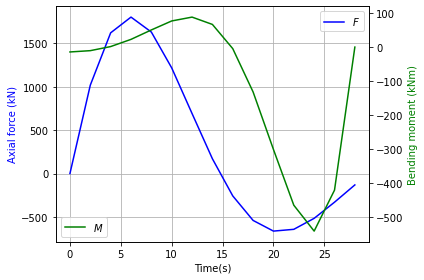

In [7]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(t,F/1e3,'-b',label = '$F$')
ax1.legend()
ax1.set_ylabel('Axial force (kN)',color = 'b')
ax1.set_xlabel('Time(s)',color = 'k')

# ax1.set_title('Loads on the assembly')
ax2.plot(t,M/1e3,'-g',label = '$M$')
ax2.legend(loc='lower left')
ax2.set_ylabel('Bending moment (kNm)',color = 'g')
ax1.grid(True)

fig.tight_layout()

fig.savefig(r'files\images\pdf\chapter_2_externalLoad_timeHistory.pdf')


# Identifying external characteristic loads

The loads matrix $P$ or the order $(m \times n)$ is decomposed to its component matrices $U^0$, $\Sigma ^0$ and $V^0$ using singular value decomposition (SVD). 

$$svd(P) = U^0 \cdot \Sigma ^0 \cdot (V^0)^T $$

The decomposed matrices is then reduced in rank to identify the two component matrices $U_k^0$ and $L_k^0$ which have a a rank equal to $k \times n$ and $ k << n $ such that

$$
P_k = U_k^0 \cdot L_k^0 \\
P \approx P_k
$$

where $L_k^0$ is the external characteristic load and is equal to 

$$ L_k^0 = \Sigma _k^0 \cdot (V_k^0)^T$$

The error between the reconstructed matrix and the original is given by calculating the Frobenius norm,

$$
\begin{align}
\epsilon _p = \frac{\lvert \lvert P-P_k \rvert \rvert _F}{\lvert \lvert P \rvert \rvert _F}
\end {align}
$$

In [8]:
Uk0,Lk0,err_external_recon = svd_reducedrank(P, 2,  flag_balance_external_load)# (A, k, flag_balance)
Pk = np.dot(Uk0, Lk0) #reconstructed external load case

print('Reconstructed load case set has a Frobenius norm error = ', err_external_recon,'%')

Reconstructed load case set has a Frobenius norm error =  1.2258478091983666e-14 %


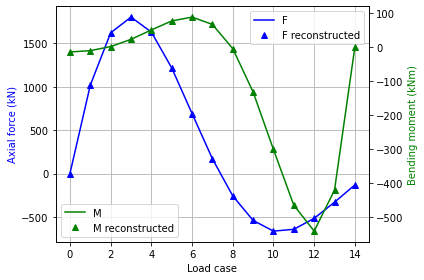

In [9]:
#Plot reconstructed loads
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(F/1e3,'-b',label = 'F')
ax1.plot(np.array(Pk[:,[0]])/1e3,'^b',label = 'F reconstructed',lw = 3)
ax1.legend(fontsize = 10)
ax1.set_ylabel('Axial force (kN)',color = 'b')
ax1.set_xlabel('Load case',color = 'k')
# ax1.set_title('Loads on the assembly')
ax2.plot(M/1e3,'-g',label = 'M')
ax2.plot(np.array(Pk[:,[1]])/1e3,'^g',label = 'M reconstructed',lw = 3)
ax2.legend(loc='lower left', fontsize = 10)
ax2.set_ylabel('Bending moment (kNm)',color = 'g')
ax1.grid(True)

plt.tight_layout()

plt.savefig(r'files\images\pdf\chapter_2_externalLoad_timeHistory_reconstructed.pdf')


# Internal loads within the elements

The total strain in the system is a sum total of the strain due to the axial loads $\epsilon _0$ and the bending load $\frac{y}{R}$. Thus strain,


$$
\epsilon = \epsilon _0 + \frac{y}{R}
$$

The internal stress in each of the material is given by

Tube, represented by the subscript 1:

$$
\sigma _{1} = E_{1} (\epsilon) = E_{1} \big (\epsilon _0 + \frac{y}{R} \big)
$$

Tube, represented by the subscript 2:

$$
\sigma _{2} = E_{2} (\epsilon) = E_{2} \big (\epsilon _0 + \frac{y}{R} \big)
$$

At equilibrium, the sum of the internal forces is equal to the external load applied. Thus,

Force equilibrium:

$$
\int _{A_1} \sigma_1 dA +\int_{A_2} \sigma _2  dA = F
$$

$$
E_1 \int _{A_1} \big(\epsilon _0 + \frac{y}{R} \big)  dA + E_2 \int_{A_2} \big(\epsilon _0 + \frac{y}{R} \big) dA = F
$$

$$
E_1 A_1 \epsilon_0 + \frac{E_1}{R} \int _{A_1} y dA + E_2 A_2 \epsilon_0 + \frac{E_2}{R} \int_{A_2} y dA = F
$$

If the individual elements are symmetrical about the neutral axis, then $\int_A y dA = 0$ which leads to

$$
E_1 A_1 \epsilon_0  + E_2 A_2 \epsilon_0  = F
$$

$$
\epsilon _0 = \frac{F}{\big( E_1 A_1 + E_2 A_2 \big)}
$$

The above should be the same result as for the case with no bending

Moment equilibrium: 

$$
\int _{A_1} \sigma_1 \, y\, dA \, + \int_{A_2} \sigma _2 \, y \, dA = M
$$

$$
E_1 \int _{A_1} \big(\epsilon _0 + \frac{y}{R} \big) \, y \, dA + E_2 \int_{A_2} \big(\epsilon _0 + \frac{y}{R} \big)\, y\, dA = M
$$

$$
E_1 \epsilon_0 \int_{A_1} y \, dA + \frac{E_1}{R} \int_{A1} y^2 dA + E_2 \epsilon_0 \int_{A_2} y \, dA + \frac{E_2}{R} \int_{A_2} y^2 dA = M
$$

If the individual elements are symmetrical about the neutral axis, then $\int_A y dA = 0$ which leads to

$$
\frac{E_1}{R} \int_{A1} y^2 dA + \frac{E_2}{R} \int_{A_2} y^2 dA = M
$$

if $\int_{A} y^2 dA  = I$ is the polar moment of inertial, then

$$
\frac{E_1}{R} I_1+ \frac{E_2}{R} I_2 = M
$$

$$
\frac{1}{R} = \frac{M}{\big( E_1 I_1 + E_2 I_2 \big)}
$$

The stresses in the individual bars can then be recovered from the stress strain relations above. Note that there will be two criteria to be checked for each bar in both tension and compression, one each at $y=±d/2$ where $d/2$ is the distance of the maximum fiber from the neutral axis.

# Identify internal characteristic loads

The relationship between internal loads and external loads is established by $\Gamma$ such that,

$$ N = P \cdot \Gamma $$


$$ \Gamma = \begin{bmatrix}
\frac{E_1 A_1}{(E_1 A_1 + E_2 A_2)} & 0 & \frac{E_2 A_2}{(E_1 A_1 + E_2 A_2)} & 0  \\
 0 & \frac{E_1 I_1}{(E_1 I_1 + E_2 I_2)} & 0 & \frac{E_2 I_2}{(E_1 I_1 + E_2 I_2)} \\
\end{bmatrix}
$$

$N$ is the internal load case set of the assembly and for a set of $m$ load cases,

$$ N = \begin{bmatrix}
f_1^t & m_1^t &f_1^b &m_1^b \\
f_2^t & m_2^t &f_2^b &m_2^b \\
\vdots &\vdots & \vdots & \vdots \\
f_m^t & m_m^t &f_m^b &m_m^b \\
\end{bmatrix}
$$

$f^t$ , $m^t$, $f^b$, $m^b$ are axial force in tube, bending moment in tube, axial force in bar, bending moment in tube respectively.

The external characteristic load set $L_k^0$ identified in the previous step in multiplied with $\Gamma$ to get the internal responses of the external characteristic loads given by $L_kN^0$

$$L_{kN}^0= L_k^0 \cdot \Gamma  $$

Also note that the internal response to all the load cases in the set $P$ can be reconstructed as 

$$ N_k^0 = U_K^0 \cdot L_{KN}^0 $$


$$ N \approx N_k^0$$

The internal response to external characteristic loads $L_{kN}^0$ can be further decomposed using $svd$ and reduced rank approximation 

$$ svd(L_{kN}^0) \approx U_k^1 \cdot L_k^1 $$

Here $L_k^1$ is the internal characteristic loads set. The approximate internal loads in terms of $L_k^1$ is given as

$$ N_k^1 = U_k^0 \cdot U_k^1 \cdot L_k^1 $$

$$N \approx N_k^1$$

For further simplification, $$U = U_k^0 \cdot U_k^1$$ The performance envelope will be identified in this $U$ space.

In [10]:
#Compute internal load of the assembly
P2N = np.array([[E1*A1/k1,0,E2*A2/k1,0],[0,E1*I1/k2,0,E2*I2/k2]]) #Gamma matrix relating force and moment in tube and bar to external force and moment on assembly

N = np.dot(P,P2N) #Internal loads

Lk_N0 = np.dot(Lk0,P2N) #Internal characteristic loads from external characteristic loads

In [11]:
N

array([[ 0.00000000e+00, -8.14933494e+03,  0.00000000e+00,
        -6.19544785e+03],
       [ 1.83423657e+05, -5.97475308e+03,  8.34370772e+05,
        -4.54224441e+03],
       [ 2.92036701e+05,  8.47923419e+02,  1.32843762e+06,
         6.44625035e+02],
       [ 3.24708052e+05,  1.28737190e+04,  1.47705542e+06,
         9.78711210e+03],
       [ 2.93673812e+05,  2.86230331e+04,  1.33588464e+06,
         2.17603657e+04],
       [ 2.19280493e+05,  4.36172747e+04,  9.97478934e+05,
         3.31595833e+04],
       [ 1.24566228e+05,  5.00573983e+04,  5.66635847e+05,
         3.80556209e+04],
       [ 3.06529302e+04,  3.78277836e+04,  1.39436261e+05,
         2.87581824e+04],
       [-4.64465641e+04, -2.56555016e+03, -2.11279483e+05,
        -1.95043305e+03],
       [-9.73885456e+04, -7.49387829e+04, -4.43008046e+05,
        -5.69714369e+04],
       [-1.19540813e+05, -1.70935510e+05, -5.43775880e+05,
        -1.29951959e+05],
       [-1.15857259e+05, -2.64019944e+05, -5.27019863e+05,
      

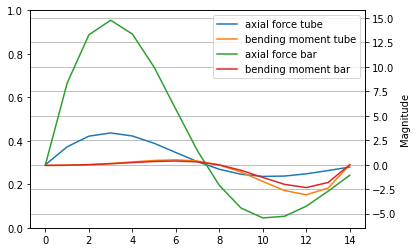

In [12]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['font.size'] = 10

plt.ylabel('Magnitude')
plt.xlabel('Load case number')
plt.plot(N[:,0]/1e5)
plt.plot(N[:,1]/1e5)
plt.plot(N[:,2]/1e5)
plt.plot(N[:,3]/1e5)
plt.legend(['axial force tube','bending moment tube', 'axial force bar', 'bending moment bar'], fontsize = 10)
plt.grid (True)


plt.savefig(r'files\images\pdf\InternalLoad_timeHistory.pdf')


plt.show()

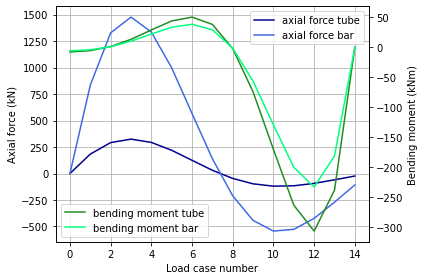

In [13]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['font.size'] = 10

ax1.set_ylabel('Axial force (kN)')
ax1.set_xlabel('Load case number')
ax1.plot(N[:,0]/1e3,'darkblue')
ax2.plot(N[:,1]/1e3,'forestgreen')
ax1.plot(N[:,2]/1e3,'royalblue')
ax2.plot(N[:,3]/1e3,'springgreen')

ax2.set_ylabel('Bending moment (kNm)')
ax1.legend(['axial force tube','axial force bar'], fontsize = 10)
ax2.legend(['bending moment tube','bending moment bar'], fontsize = 10)

ax1.grid (True)

plt.tight_layout()

plt.savefig(r'files\images\pdf\chapter_2_InternalLoad_timeHistory.pdf')


plt.show()

## Balancing/Scaling of loads

Balancing is a way to get a good SVD decomposition.

$$ L_{kNB}^0 = L_{kN}^0 \cdot S_B $$

$L_{kNB}^0$ is the balanced internal response to the external characteristic load and $S_B$ is the balancing matrix.

$$ L_{kN}^0 = L_{kNB}^0 \cdot S_B^{-1} $$

Performing SVD on $L_{kNB}^0$,

$$
svd(L_{kNB}^0) = U_k^1 \cdot L_k^1
$$

The original matrix $L_{kN}^0$ is recovered as,

$$
L_{kN}^0 = U_k^1 \cdot L_k^1 \cdot S_B^{-1}
$$

The balancing matrix $S_B$ is a diagonal matrix and each entry of the diagonal is given by the norm of the column of $L_{kN}^0$ matrix

$$
S_B = 
\begin{pmatrix}
    {S_{B_1}}\\
    &{S_{B_2}}\\
    &&{S_{B_3}}\\
    &&&{S_{B_4}}\\
\end{pmatrix}
$$


$$
S_{B_i} = \lvert \lvert{L_{kN_{1:4,i}}^0}\rvert \rvert
$$

In [14]:
#internal characteristic loads
Uk1,Lk1,err_internal = svd_reducedrank(Lk_N0, 2,  flag_balance_internal_load) # (A, k, flag_balance)

In [15]:
err_internal_list = []
for k in list(range(1,5)):
    _,_,err_internal_temp = svd_reducedrank(N, k,  flag_balance_internal_load) # (A, k, flag_balance)
    err_internal_list.append(err_internal_temp)

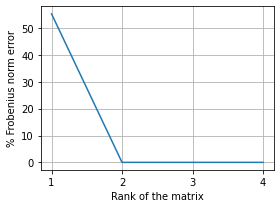

In [16]:
fig, ax = plt.subplots(figsize=(4,3))

plt.plot([1,2,3,4],err_internal_list)
plt.ylabel('% Frobenius norm error')
plt.xlabel('Rank of the matrix')

plt.xticks([1,2,3,4])

plt.tight_layout()
plt.grid(True)

plt.savefig(r'files\images\pdf\chatper_2_Rank_error.pdf')

plt.show()

### Reconstruction error

The reconstruction error of the internal loads from the characteristic loads is given by

$$ \epsilon _{N_k^0} = \frac{\lvert \lvert N-N_k^0 \rvert \rvert _F}{\lvert \lvert N \rvert \rvert _F} $$

and 
$$ \epsilon _{N_k^1} = \frac{\lvert \lvert N-N_k^1 \rvert \rvert _F}{\lvert \lvert N \rvert \rvert _F} $$


In [17]:
#Compute reconstruction error
Nk0 = np.dot(Uk0,Lk_N0)
Nk1 = np.dot(np.dot(Uk0,Uk1),Lk1)

err_Nk0 = (np.linalg.norm(N-Nk0))*100/(np.linalg.norm(N,ord = 'fro'))

err_Nk1 = (np.linalg.norm(N-Nk1))*100/(np.linalg.norm(N,ord = 'fro'))

print('\n Reconstructed internal load case set from Nk0 has a Frobenius norm error = ', err_Nk0,'%','\n')
print('\n Reconstructed internal load case set from Nk1 has a Frobenius norm error = ', err_Nk1,'%','\n')


 Reconstructed internal load case set from Nk0 has a Frobenius norm error =  1.3645113140134239e-14 % 


 Reconstructed internal load case set from Nk1 has a Frobenius norm error =  1.9358575425994188e-14 % 



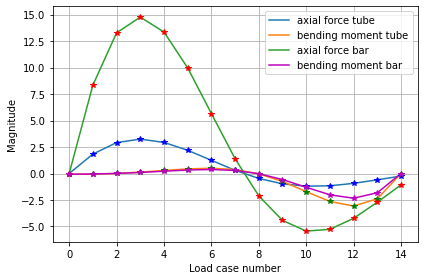

In [18]:
plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['font.size'] = 10

plt.ylabel('Magnitude')
plt.xlabel('Load case number')
plt.plot(N[:,0]/1e5)
plt.plot(N[:,1]/1e5)
plt.plot(N[:,2]/1e5)
plt.plot(N[:,3]/1e5,'m-')

plt.plot(Nk0[:,0]/1e5,'b*')
plt.plot(Nk0[:,1]/1e5, 'g*')
plt.plot(Nk0[:,2]/1e5, 'r*')
plt.plot(Nk0[:,3]/1e5, 'm*')

plt.legend(['axial force tube','bending moment tube', 'axial force bar', 'bending moment bar'], fontsize = 10)
plt.grid (True)
plt.tight_layout()

plt.savefig(r'files\images\pdf\InternalLoad_timeHistory_reconstructed.pdf')

plt.show()

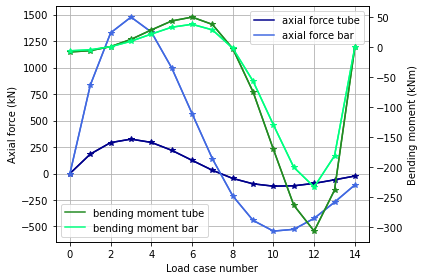

In [19]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['font.size'] = 10

ax1.set_ylabel('Axial force (kN)')
ax1.set_xlabel('Load case number')


ax1.plot(N[:,0]/1e3,'darkblue')
ax2.plot(N[:,1]/1e3,'forestgreen')
ax1.plot(N[:,2]/1e3,'royalblue')
ax2.plot(N[:,3]/1e3,'springgreen')

ax1.plot(Nk0[:,0]/1e3,'darkblue', marker = '*')
ax2.plot(Nk0[:,1]/1e3,'forestgreen', marker = '*')
ax1.plot(Nk0[:,2]/1e3,'royalblue', marker = '*')
ax2.plot(Nk0[:,3]/1e3,'springgreen', marker = '*')

ax2.set_ylabel('Bending moment (kNm)')
ax1.legend(['axial force tube','axial force bar'], fontsize = 10)
ax2.legend(['bending moment tube','bending moment bar'], fontsize = 10)

ax1.grid (True)

plt.tight_layout()
plt.savefig(r'files\images\pdf\chapter_2_InternalLoad_timeHistory_reconstructed.pdf')


plt.show()

# Performance envelopes

## Reserve factors and constraints

Reserve factor (RF) is a parameter to quantify the failure constraint of a structure and is defined as the ratio of the allowable to actual values

$$ RF = \frac{allowable}{actual}$$

If the RF is greater than 1, then the structure is safe and if the RF is lesser than one then the structure would fail. 

The stress $\sigma$ inside the assembly is given by

$$ \sigma = \left (\frac{f}{A} + \frac{m y}{I}\right )$$

$f$ and $m$ are the internal axial load and bending moment, $A$ and $I$ are the cross sectional area and moment of inertia  and $y$ is the maximum distance of the fiber from the neutral axis. Note that $y$ can be both positive or negative.

$$ RF = \frac {\sigma _y}{\sigma}$$

$\sigma _y$ is the limiting stress each for tube and bar either in tension or compression.

There are eight failure constraints for the assembly given by,

$$
\sigma _{y_1} ^{compression} < \sigma _{1}^{y = \frac{x_1}{2}} < \sigma_{y_1}^{tension}
$$
$$
\sigma _{y_2} ^{compression} < \sigma _{2}^{y = \frac{x_3}{2}} < \sigma_{y_2}^{tension}
$$
$$
\sigma _{y_1} ^{compression} < \sigma _{1}^{y = \frac{-x_1}{2}} < \sigma_{y_1}^{tension}
$$
$$
\sigma _{y_2} ^{compression} < \sigma _{2}^{y = \frac{-x_3}{2}} < \sigma_{y_2}^{tension}
$$

The reserve factor set is represented as,

$$
RF = \begin{bmatrix}
           RF_{1} \\
           RF_{2} \\
           \vdots \\
           RF_{8}
         \end{bmatrix}
$$


In [20]:
u_pe1 = envelope_2D_BuildandRefine(prop, r_ini, Lk1, thetaInitial, False, maxPoints) #(prop, r_ini, lk, thetaInitial, flag_refine, maxPoints)


### Mapping constraints on to envelope

Actual failure constraint are mapped from the external load space to the characteristic load space by solving. If $P_{cri}$ is a set of external critical loads then,

$$ N_{cri} = P_{cri} \cdot \Gamma $$

$N_{cri}$ is the corresponding set of internal critical loads and they are converted to critical characteristic load as

$$ U_{cri} = N_{cri} \cdot L_k^1$$

In [21]:
#Solving constraints in external load space
p=np.linspace(-0.1e8,0.1e8,3)

M1_ten = k2*(ten1-E1*(p)/k1)/(y1*E1)
M1_com = k2*(com1-E1*(p)/k1)/(y1*E1)
M2_ten = k2*(ten2-E2*(p)/k1)/(y2*E2)
M2_com = k2*(com2-E2*(p)/k1)/(y2*E2)

M1_ten_m = k2*(ten1-E1*(p)/k1)/(-y1*E1)
M1_com_m = k2*(com1-E1*(p)/k1)/(-y1*E1)
M2_ten_m = k2*(ten2-E2*(p)/k1)/(-y2*E2)
M2_com_m = k2*(com2-E2*(p)/k1)/(-y2*E2)

constraint_1 = np.vstack((p,M1_ten))
constraint_2 =  np.vstack((p,M1_com))
constraint_3 =  np.vstack((p,M2_ten))
constraint_4 =  np.vstack((p,M2_com))
constraint_5 =  np.vstack((p,M1_ten_m))
constraint_6 =  np.vstack((p,M1_com_m))
constraint_7 =  np.vstack((p,M2_ten_m))
constraint_8 =  np.vstack((p,M2_com_m))

#Convert to internal loads
internal_c1 = np.dot(constraint_1.T,P2N)
internal_c2 = np.dot(constraint_2.T,P2N)
internal_c3 = np.dot(constraint_3.T,P2N)
internal_c4 = np.dot(constraint_4.T,P2N)
internal_c5 = np.dot(constraint_5.T,P2N)
internal_c6 = np.dot(constraint_6.T,P2N)
internal_c7 = np.dot(constraint_7.T,P2N)
internal_c8 = np.dot(constraint_8.T,P2N)

#Convert to characteristic load space
cL_c1 = np.dot(internal_c1,np.linalg.pinv(Lk1))
cL_c2 = np.dot(internal_c2,np.linalg.pinv(Lk1))
cL_c3 = np.dot(internal_c3,np.linalg.pinv(Lk1))
cL_c4 = np.dot(internal_c4,np.linalg.pinv(Lk1))
cL_c5 = np.dot(internal_c5,np.linalg.pinv(Lk1))
cL_c6 = np.dot(internal_c6,np.linalg.pinv(Lk1))
cL_c7 = np.dot(internal_c7,np.linalg.pinv(Lk1))
cL_c8 = np.dot(internal_c8,np.linalg.pinv(Lk1))

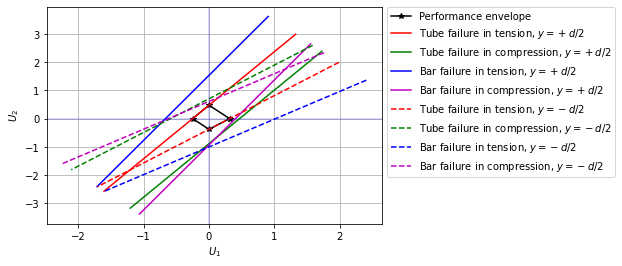

In [22]:
## plt.rcParams['figure.figsize'] = (6, 10)
plt.rcParams['font.size'] = 10

plt.plot(u_pe1[:,[0]],u_pe1[:,[1]],'k*-')
plt.plot(cL_c1[:,[0]],cL_c1[:,[1]],'r-')
plt.plot(cL_c2[:,[0]],cL_c2[:,[1]],'g-')
plt.plot(cL_c3[:,[0]],cL_c3[:,[1]],'b-')
plt.plot(cL_c4[:,[0]],cL_c4[:,[1]],'m-')
plt.plot(cL_c5[:,[0]],cL_c5[:,[1]],'r--')
plt.plot(cL_c6[:,[0]],cL_c6[:,[1]],'g--')
plt.plot(cL_c7[:,[0]],cL_c7[:,[1]],'b--')
plt.plot(cL_c8[:,[0]],cL_c8[:,[1]],'m--')
plt.legend(['Performance envelope','Tube failure in tension, $y =+d/2$','Tube failure in compression, $y =+d/2$','Bar failure in tension, $y =+d/2$',
           'Bar failure in compression, $y =+d/2$','Tube failure in tension, $y =-d/2$','Tube failure in compression, $y =-d/2$','Bar failure in tension, $y =-d/2$',
           'Bar failure in compression, $y =-d/2$'], fontsize = 10,loc= 'upper left',bbox_to_anchor=(1, 1.02))
plt.xlabel('$U_1$', fontsize = 10)
plt.ylabel('$U_2$')
plt.axhline(0, color='blue', alpha = 0.2)
plt.axvline(0, color='blue', alpha = 0.2)
plt.grid(True)

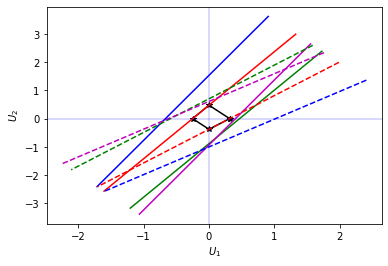

In [23]:
fig, ax = plt.subplots(figsize = (6,4))
plt.plot(u_pe1[:,[0]],u_pe1[:,[1]],'k*-')
plt.plot(cL_c1[:,[0]],cL_c1[:,[1]],'r-')
plt.plot(cL_c2[:,[0]],cL_c2[:,[1]],'g-')
plt.plot(cL_c3[:,[0]],cL_c3[:,[1]],'b-')
plt.plot(cL_c4[:,[0]],cL_c4[:,[1]],'m-')
plt.plot(cL_c5[:,[0]],cL_c5[:,[1]],'r--')
plt.plot(cL_c6[:,[0]],cL_c6[:,[1]],'g--')
plt.plot(cL_c7[:,[0]],cL_c7[:,[1]],'b--')
plt.plot(cL_c8[:,[0]],cL_c8[:,[1]],'m--')
# plt.legend(['Performance envelope','Tube failure in tension','Tube failure in compression','Bar failure in tension',
#            'Bar failure in compression','Tube failure in tension, $y =-d/2$','Tube failure in compression, $y =-d/2$','Bar failure in tension, $y =-d/2$',
#            'Bar failure in compression, $y =-d/2$'], fontsize = 10,loc= 'upper left',bbox_to_anchor=(1, 1.02))
plt.xlabel('$U_1$')
plt.ylabel('$U_2$')
plt.axhline(0, color='blue', alpha = 0.2)
plt.axvline(0, color='blue', alpha = 0.2)


plt.savefig(r'files\images\pdf\PE_with_initial_points.pdf')




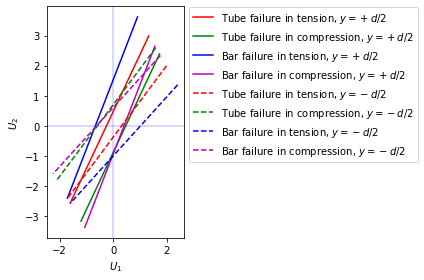

In [24]:
fig, ax = plt.subplots(figsize = (6,4))

plt.plot(cL_c1[:,[0]],cL_c1[:,[1]],'r-')
plt.plot(cL_c2[:,[0]],cL_c2[:,[1]],'g-')
plt.plot(cL_c3[:,[0]],cL_c3[:,[1]],'b-')
plt.plot(cL_c4[:,[0]],cL_c4[:,[1]],'m-')
plt.plot(cL_c5[:,[0]],cL_c5[:,[1]],'r--')
plt.plot(cL_c6[:,[0]],cL_c6[:,[1]],'g--')
plt.plot(cL_c7[:,[0]],cL_c7[:,[1]],'b--')
plt.plot(cL_c8[:,[0]],cL_c8[:,[1]],'m--')
plt.legend(['Tube failure in tension, $y =+d/2$','Tube failure in compression, $y =+d/2$','Bar failure in tension, $y =+d/2$',
           'Bar failure in compression, $y =+d/2$','Tube failure in tension, $y =-d/2$','Tube failure in compression, $y =-d/2$','Bar failure in tension, $y =-d/2$',
           'Bar failure in compression, $y =-d/2$'], fontsize = 10,loc= 'upper left',bbox_to_anchor=(1, 1.02))
plt.xlabel('$U_1$')
plt.ylabel('$U_2$')
plt.axhline(0, color='blue', alpha = 0.2)
plt.axvline(0, color='blue', alpha = 0.2)

plt.tight_layout()

plt.savefig(r'files\images\pdf\Mapped_constraints_legend.pdf')


plt.show()

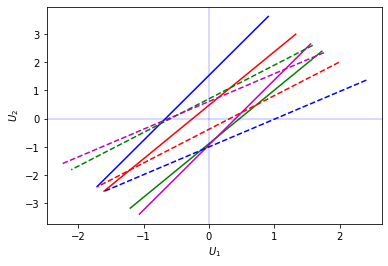

In [25]:
plt.plot(cL_c1[:,[0]],cL_c1[:,[1]],'r-')
plt.plot(cL_c2[:,[0]],cL_c2[:,[1]],'g-')
plt.plot(cL_c3[:,[0]],cL_c3[:,[1]],'b-')
plt.plot(cL_c4[:,[0]],cL_c4[:,[1]],'m-')
plt.plot(cL_c5[:,[0]],cL_c5[:,[1]],'r--')
plt.plot(cL_c6[:,[0]],cL_c6[:,[1]],'g--')
plt.plot(cL_c7[:,[0]],cL_c7[:,[1]],'b--')
plt.plot(cL_c8[:,[0]],cL_c8[:,[1]],'m--')

plt.xlabel('$U_1$')
plt.ylabel('$U_2$')
plt.axhline(0, color='blue', alpha = 0.2)
plt.axvline(0, color='blue', alpha = 0.2)


plt.savefig(r'files\images\pdf\Mapped_constraints_2.pdf')


plt.show()

The plot describes all the constraints of the assembly mapped on to the characteristic load space. Each line represents a type of failure of the assembly. For example, the red line describes the failure of the tube in tension where as the magenta represents the failure of the bar in compression. Note the there are eight constraints in the problem. The dashed line constraints represent the failure of the assembly when $y = \pm d/2$. This is due to the fact that the assembly is subjected to bending moment and thus the failure can occur on either side of the neutral axis.

The region around the origin in this characteristic load space surrounded by the critical constraints is called the performance envelope. Any point on this envelope is a combination of loads which will just cause the assembly to fail. 

Also note that the performance envelope identifies all the non-redundant constraints of the structure. For example, the green lines which represent the failure of the tube is not a part of the envelope and thus is never critical. These constraints if sufficiently far away from the envelope can be ignored.

## Envelope mesh refinement

In [26]:
u_pe = envelope_2D_BuildandRefine(prop, r_ini, Lk1, thetaInitial, True, maxPoints) #(prop, r_ini, lk, thetaInitial, flag_refine, maxPoints)


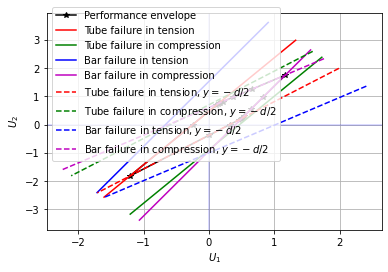

In [27]:

plt.plot(u_pe[:,[0]],u_pe[:,[1]],'k*-')
plt.plot(cL_c1[:,[0]],cL_c1[:,[1]],'r-')
plt.plot(cL_c2[:,[0]],cL_c2[:,[1]],'g-')
plt.plot(cL_c3[:,[0]],cL_c3[:,[1]],'b-')
plt.plot(cL_c4[:,[0]],cL_c4[:,[1]],'m-')
plt.plot(cL_c5[:,[0]],cL_c5[:,[1]],'r--')
plt.plot(cL_c6[:,[0]],cL_c6[:,[1]],'g--')
plt.plot(cL_c7[:,[0]],cL_c7[:,[1]],'b--')
plt.plot(cL_c8[:,[0]],cL_c8[:,[1]],'m--')

plt.legend(['Performance envelope','Tube failure in tension','Tube failure in compression','Bar failure in tension',
           'Bar failure in compression','Tube failure in tension, $y =-d/2$','Tube failure in compression, $y =-d/2$','Bar failure in tension, $y =-d/2$',
           'Bar failure in compression, $y =-d/2$'], fontsize = 10,loc= 'upper left',bbox_to_anchor=(-0, 1.05))
plt.xlabel('$U_1$')
plt.ylabel('$U_2$')
plt.axhline(0, color='blue', alpha = 0.2)
plt.axvline(0, color='blue', alpha = 0.2)
plt.grid(True)
# plt.

plt.savefig(r'files\images\pdf\compoundBar2D_performanceEnvelope_1.pdf')


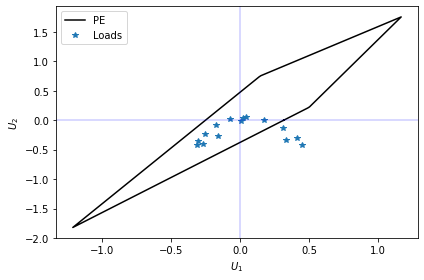

In [28]:
check_u = np.dot(N, np.linalg.pinv(Lk1))

fig, ax = plt.subplots(figsize = (6,4))
plt.plot(u_pe[:,[0]],u_pe[:,[1]],'k-')
# plt.plot(Uk0[10,0],Uk0[10,1],'*')
plt.plot(check_u[:,0],check_u[:,1],'*')
plt.xlabel('$U_1$')
plt.ylabel('$U_2$')
plt.axhline(0, color='blue', alpha = 0.2)
plt.axvline(0, color='blue', alpha = 0.2)
plt.legend(['PE', 'Loads'], fontsize = 10)

plt.tight_layout()

plt.savefig(r'files\images\pdf\Envelope_with_loads.pdf')

plt.show()

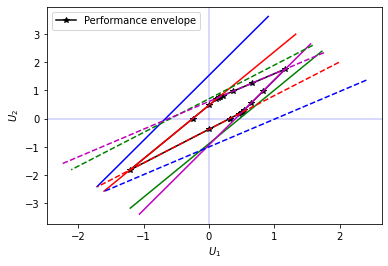

In [29]:
fig, ax = plt.subplots(figsize = (6,4))

plt.plot(u_pe[:,[0]],u_pe[:,[1]],'k*-')
plt.plot(cL_c1[:,[0]],cL_c1[:,[1]],'r-')
plt.plot(cL_c2[:,[0]],cL_c2[:,[1]],'g-')
plt.plot(cL_c3[:,[0]],cL_c3[:,[1]],'b-')
plt.plot(cL_c4[:,[0]],cL_c4[:,[1]],'m-')
plt.plot(cL_c5[:,[0]],cL_c5[:,[1]],'r--')
plt.plot(cL_c6[:,[0]],cL_c6[:,[1]],'g--')
plt.plot(cL_c7[:,[0]],cL_c7[:,[1]],'b--')
plt.plot(cL_c8[:,[0]],cL_c8[:,[1]],'m--')

plt.legend(['Performance envelope'], fontsize = 10)
plt.xlabel('$U_1$')
plt.ylabel('$U_2$')
plt.axhline(0, color='blue', alpha = 0.2)
plt.axvline(0, color='blue', alpha = 0.2)
# plt.grid(True)

plt.savefig(r'files\images\pdf\compoundBar2D_performanceEnvelope_1.pdf')

plt.show()

In [30]:
u_pe.shape

(21, 2)

# Fast RF estimation

The performance envelope represents the maximum allowable load a structure can carry before a failure can occur. The RF for a load case can thus be computed as the ratio of the magnitude of the vector of the load case $(r_{𝑎𝑐𝑡𝑢𝑎𝑙})$ in the characteristic load space to the intersection of the loads vector with the performance envelope $(𝑟_{𝑎𝑙𝑙𝑜𝑤𝑎𝑏𝑙𝑒})$ as shown below.

<img src="files/FastRF_1.png" alt="FastRF_1" style="width: 40%;"/>




$$ RF = \frac{\vert r_{allowable} \vert}{\vert r_{actual} \vert}$$


The intersection between the load vector and the envelope surface (allowable vector $𝑟_{𝑎𝑙𝑙𝑜𝑤𝑎𝑏𝑙𝑒}$ ) is calculated using a ray-hyperplane intersection algorithm. This is a purely geometrical calculation which is extremely fast since all the redundant constraints and detailed stressing calculations have been eliminated in the construction of the envelope. Using this fast RF estimation approach a large number of load cases can be accurately evaluated for their critical 𝑅𝐹 without having to solve the system of equations. For a set of test loads, the critical RF for each load case computed through the fast RF method (RF estimated) and critical RF computed by analytical means (RF actual).

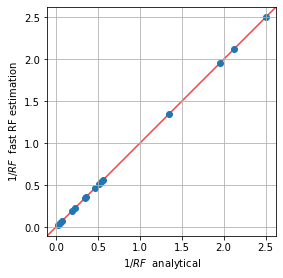

In [31]:
testLoads = np.dot(N,np.linalg.pinv(Lk1))
RF_testLoads_FastRF =FastRF_2D(u_pe,testLoads)
# print('RF estimated from Fast RF method is {}' .format(RF_testLoads_FastRF[0,0]))

#Validation 
theta_loads,r_loads = cart2pol(testLoads[:,[0]],testLoads[:,[1]])
RFmin_testLoads, RF_ind_loads = checkRF_2D(prop, Lk1, r_loads, theta_loads)
# print('RF calculated from solving analytical equation is'.format(RFmin_testLoads[0]))

# %matplotlib notebook
fig, ax = plt.subplots(figsize=(4,4))
plt.scatter(1/RFmin_testLoads,1/RF_testLoads_FastRF)

#Identity line
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
# now plot both limits against eachother
ax.plot(lims, lims, 'r-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
# plt.title('Critical $RF$ for 10 load cases. Fast RF vs Analytical', fontsize = 10)
plt.xlabel('$1/RF$  analytical', fontsize = 10)
plt.ylabel('$1/RF$  fast RF estimation', fontsize = 10)
plt.grid(True)
plt.tight_layout()

plt.savefig(r'files\images\pdf\chapter_2_compoundBar2D_FastRF_1.pdf')


In [32]:
RF_testLoads_FastRF

array([[14.63622085],
       [ 5.28361508],
       [ 4.37270944],
       [ 2.82243344],
       [ 2.16076734],
       [ 1.87947381],
       [ 1.94479403],
       [ 2.93768378],
       [20.47458798],
       [ 1.80378451],
       [ 0.74492662],
       [ 0.47044996],
       [ 0.39916344],
       [ 0.51080946],
       [53.64112042]])

In [33]:
cri_index = np.argwhere(RF_testLoads_FastRF < 2)[:,0]

In [34]:
plt.rcParams['font.size'] = 10 

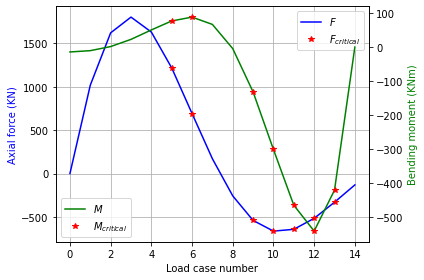

In [35]:
#Plot loads
fig, ax1 = plt.subplots(figsize = (6,4))

ax2 = ax1.twinx()

ax1.plot(list(range(0,15)),F/1e3,'-b',label = '$F$')
ax1.plot(cri_index,F[cri_index]/1e3,'r*',label = '$F_{critical}$')
ax1.legend()
ax1.set_ylabel('Axial force (KN)',color = 'b')
ax1.set_xlabel('Load case number',color = 'k')

ax2.plot(list(range(0,15)),M/1e3,'-g',label = '$M$')
ax2.plot(cri_index,M[cri_index]/1e3,'r*',label = '$M_{critical}$')
ax2.legend(loc='lower left')
ax2.set_ylabel('Bending moment (KNm)',color = 'g')
ax1.grid(True)
plt.tight_layout()
plt.savefig(r'files\images\pdf\externalLoad_timeHistory_with_criticalLoad.pdf')
plt.show()

In [36]:
RF_testLoads_FastRF[10]

array([0.74492662])

In [37]:
#Check if the failure mode of the ciritcal loads match with performance envelope

min_ind = []
for i in range(0,N.shape[0]):
    
    _,_, temp_ind = checkRF_2D_V3(prop, N[i])
    min_ind.append(temp_ind)
    
min_ind


[4, 4, 0, 0, 0, 0, 0, 0, 3, 4, 4, 4, 4, 4, 3]

In [38]:
checkRF_2D_V3(prop, N[12])

([100000000000.0,
  0.7050741538924632,
  100000000000.0,
  0.6479905065591246,
  0.39916344277785565,
  100000000000.0,
  1.1775747761489046,
  100000000000.0],
 0.39916344277785565,
 4)

In [39]:
# Accuracy of Fast RF with different number of points

u_pe_few_points = envelope_2D_BuildandRefine(prop, r_ini, Lk1, thetaInitial, True, 6) #(prop, r_ini, lk, thetaInitial, flag_refine, maxPoints)


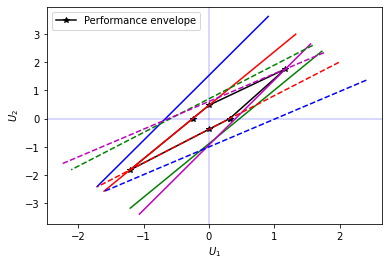

In [40]:
fig, ax = plt.subplots(figsize = (6,4))

plt.plot(u_pe_few_points[:,[0]],u_pe_few_points[:,[1]],'k*-')
plt.plot(cL_c1[:,[0]],cL_c1[:,[1]],'r-')
plt.plot(cL_c2[:,[0]],cL_c2[:,[1]],'g-')
plt.plot(cL_c3[:,[0]],cL_c3[:,[1]],'b-')
plt.plot(cL_c4[:,[0]],cL_c4[:,[1]],'m-')
plt.plot(cL_c5[:,[0]],cL_c5[:,[1]],'r--')
plt.plot(cL_c6[:,[0]],cL_c6[:,[1]],'g--')
plt.plot(cL_c7[:,[0]],cL_c7[:,[1]],'b--')
plt.plot(cL_c8[:,[0]],cL_c8[:,[1]],'m--')

plt.legend(['Performance envelope'], fontsize = 10)
plt.xlabel('$U_1$')
plt.ylabel('$U_2$')
plt.axhline(0, color='blue', alpha = 0.2)
plt.axvline(0, color='blue', alpha = 0.2)
# plt.grid(True)

plt.savefig(r'files\images\pdf\compoundBar2D_performanceEnvelope_1.pdf')

plt.show()